# Tesi di laurea di Simone Persiani

## Imports and constants

In [28]:
import random

import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

Imports from PyTorch:

In [29]:
import torch

from torch.nn import BCELoss, Module, Linear, Dropout
from torch.optim import AdamW, SGD
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data.sampler import WeightedRandomSampler, SequentialSampler

Constants:

In [30]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}.")

EMBEDDINGS_SIZE = 768 # or 1024 for roberta_large
MODEL_SAVE_PATH = "./model.pt"
RANDOM_SEED = 42

config = {
  "learning_rate": 1e-5,
  "epochs": 4,  # Higher values (6, 8) usually lead to overfitting (based on my results)
  "hidden_layer_size": 64,  # Higher values (128, 256) usually lead to overfitting (based on my results), lower values (32) to underfitting!
  "batch_size": 16,
  "weight_decay": 0.01,  # NEW
  "label_smoothing": 0.05,  # NEW
  "dataset": "augmented",  # "preprocessed" | ["augmented"  # NEW]
  "max_sequence_length": 60  # lower value (30) decreases train/val accuracy (about -1%), higher values (90, 120) don't lead to any improvement
}

Using device: cuda.


Setting random seeds to obtain a deterministic behaviour:

In [31]:
def random_state(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

random_state(RANDOM_SEED)

## Download RoBERTa

Download the model and the tokenizer.

[This work](https://github.com/avramandrei/UPB-SemEval-2020-Task-6) showed that a fine-tuned RoBERTa model is the best-performing variant of BERT.

In [32]:
from transformers import RobertaModel, RobertaTokenizer

roberta_model = RobertaModel.from_pretrained("roberta-base")
roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
roberta_tokenizer.add_tokens(["<link>", "<equation>"])

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


2

## Loading the dataset

In [33]:
def load_dataset(dataset_path, tokenizer):
  df = pd.read_csv(dataset_path, sep="\t", header=0, encoding='utf-8',
                   names=["SENTENCE", "HAS_DEF"], usecols=["SENTENCE", "HAS_DEF"],
                   dtype={"SENTENCE": str, "HAS_DEF": np.uint8})

  X, y = df["SENTENCE"].tolist(), df["HAS_DEF"].tolist()

  encodings = tokenizer(X, add_special_tokens=True, max_length=config["max_sequence_length"],
                        padding="longest", truncation="longest_first",
                        return_attention_mask=True, return_tensors="pt")

  X = encodings['input_ids'].to(dtype=torch.int32, device='cpu')
  y = torch.tensor(y, dtype=torch.int64, device='cpu')
  mask = encodings['attention_mask'].to(dtype=torch.uint8, device='cpu')

  dataset = TensorDataset(X, y, mask)

  return dataset

train_ds = load_dataset(f'./dataset/{config["dataset"]}/train.tsv', roberta_tokenizer)
val_ds   = load_dataset(f'./dataset/{config["dataset"]}/dev.tsv',   roberta_tokenizer)
test_ds  = load_dataset(f'./dataset/preprocessed/test.tsv',  roberta_tokenizer)

## Dealing with an unbalanced dataset

Preparing a WeightedRandomSampler so that training batches will contain, _on average_, the same amount of positive and negative samples.

**This should address the problem of the unbalanced DEFT dataset. In general, one would expect definitions to be a relatively-rare occurrence in a Natural Language text.**

In [34]:
#def getBalancingWeights(labels):  # NEW
#    n_samples = labels.shape[0]
#    def_samples = torch.sum(labels).item()
#
#    non_def_samples = n_samples - def_samples
#
#    class_weights = {0: def_samples / n_samples,
#                    1: non_def_samples / n_samples}
#    sample_weights = torch.tensor([class_weights[label.item()] for label in labels], dtype=torch.double, device='cpu')
#
#    return sample_weights, class_weights
#
#labels = train_ds.tensors[1]
#sample_weights, class_weights = getBalancingWeights(labels)
#g = torch.Generator()
#g.manual_seed(RANDOM_SEED)
#weighted_sampler = WeightedRandomSampler(weights=sample_weights,
#                                        num_samples=len(train_ds),
#                                        replacement=True, generator=g)
## Param replacement=True means that the same sample can be selected more than once inside a single batch!

#train_loader = DataLoader(dataset=train_ds, batch_size=config["batch_size"], sampler=weighted_sampler)

train_loader = DataLoader(dataset=train_ds, batch_size=config["batch_size"], shuffle=True)
val_loader   = DataLoader(dataset=val_ds, batch_size=config["batch_size"], sampler=SequentialSampler(val_ds))
test_loader  = DataLoader(dataset=test_ds, batch_size=config["batch_size"], sampler=SequentialSampler(test_ds))

**NEW** As an alternative, use weighted loss (by weighing more the errors done on the minority class. Just like the WeightedRandomSampler, this technique must be applied to the training set ONLY (no validation/test)!

## Define the classifier model

In [35]:
class RoBERTaWithMLP(Module):
  """ See: https://github.com/avramandrei/UPB-SemEval-2020-Task-6/blob/77d92e9c386f270af6ed1db259d3ba6e8bde307b/task1/model.py#L49-L80 """
  
  def __init__(self, lang_model, vocab_size, input_size, hidden_size):
    super().__init__()
    
    self.lang_model = lang_model
    self.lang_model.resize_token_embeddings(vocab_size)

    self.linear1 = Linear(input_size, hidden_size)
    self.dropout1 = Dropout(0.8)
    self.linear2 = Linear(hidden_size, hidden_size)
    self.dropout2 = Dropout(0.8)
    self.linear3 = Linear(hidden_size, 1)

  def forward(self, x, mask):
    embeddings = self.lang_model(x, attention_mask=mask)[0]
    embeddings = torch.mean(embeddings, dim=1)

    output = self.dropout1(F.gelu(self.linear1(embeddings)))
    output = self.dropout2(F.gelu(self.linear2(output)))
    output = torch.sigmoid(self.linear3(output))

    return output

# Testing

In [36]:
model = torch.load(MODEL_SAVE_PATH, map_location=DEVICE)

In [37]:
def get_test_predictions(model):
  model.eval()

  truth = []
  predictions=[]

  with torch.no_grad():
    for (test_x, test_y, mask) in test_loader:
      # Move data to the device in use
      test_x = test_x.to(DEVICE)
      test_y = test_y.to(DEVICE)
      mask = mask.to(DEVICE)

      # Forward pass
      output = model.forward(test_x, mask)
      output = torch.reshape(output, (-1,))

      # Model predictions
      truth.extend(torch.flatten(test_y).tolist())
      predictions.extend(torch.flatten(output, 0).tolist())

  return truth, predictions

truth, predictions = get_test_predictions(model)

## Use ROC curve to determine the classification threshold

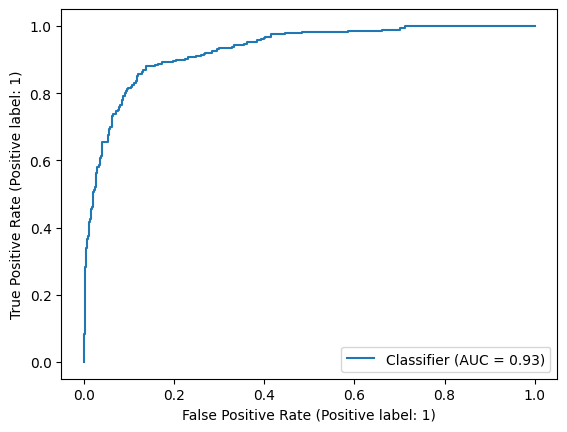

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, RocCurveDisplay, ConfusionMatrixDisplay

fpr, tpr, thresholds = roc_curve(truth, predictions, pos_label=1)

RocCurveDisplay.from_predictions(truth, predictions)  # NEW
plt.show()

TEST RESULTS:
Accuracy: 87.35%
Precision: 80.36%
Recall: 81.23%
F1: 80.79%


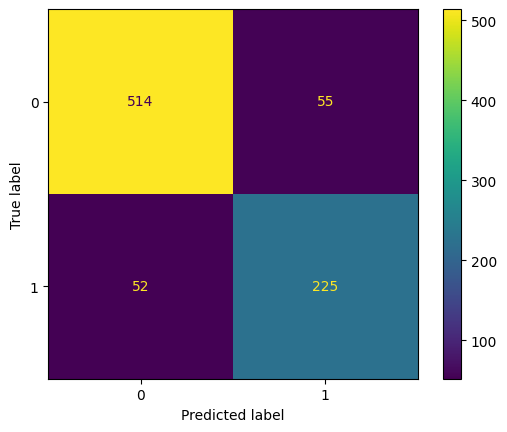

In [39]:
OPT_THRESHOLD = 0.6
results = [1 if x > OPT_THRESHOLD else 0 for x in predictions]

test_acc = 100*accuracy_score(truth, results)
test_rec = 100*recall_score(truth, results)
test_prec = 100*precision_score(truth, results)
test_f1 = 100*f1_score(truth, results)

print("TEST RESULTS:")
print(f"Accuracy: {round(test_acc, 2)}%")
print(f"Precision: {round(test_prec, 2)}%")
print(f"Recall: {round(test_rec, 2)}%")
print(f"F1: {round(test_f1, 2)}%")

ConfusionMatrixDisplay.from_predictions(truth, results)
plt.show()

In [40]:
def predict(sentence):
  encodings = roberta_tokenizer(sentence, add_special_tokens=True,
                          padding="longest", truncation="longest_first",
                          return_attention_mask=True, return_tensors="pt")
  
  X = encodings['input_ids'].to(dtype=torch.int32, device=DEVICE)
  mask = encodings['attention_mask'].to(dtype=torch.uint8, device=DEVICE)

  model.eval()
  with torch.no_grad():
    score = model.forward(X, mask).item()
  return score, 1 if score > OPT_THRESHOLD else 0

In [41]:
predict("She concluded that, if her earlier results relating the quantity of uranium to its activity were correct, then these two minerals must contain small quantities of another substance that was far more active than uranium.")

(0.17758753895759583, 0)

In [42]:
predict("In engineering, a computer is a complex electronic device capable of executing algorithms.")

(0.9247405529022217, 1)

In [43]:
predict("Radioactive decay (also known as nuclear decay, radioactivity, radioactive disintegration, or nuclear disintegration) is the process by which an unstable atomic nucleus loses energy by radiation.")

(0.9257554411888123, 1)

In [44]:
predict("Dogs are animals that have four legs and are playful.")

(0.9237014055252075, 1)

In [45]:
predict("Yellow, blue, green and red are colors.")

(0.20424801111221313, 0)

The following test definitions are taken from https://www.ucfmapper.com/education/various-types-definitions/

**Intensional definition:**

In [46]:
predict("Baked Goods are foods that are cooked in an oven of some fashion that uses prolonged dry heat, usually based on flour or corn.")

(0.9258827567100525, 1)

**Extensional definition:**

In [47]:
predict("Baked Goods are breads, cakes, pastries, cookies, biscuits, scones and similar items of food that are cooked in an oven of some fashion.")

(0.9243714213371277, 1)

**Stipulative definition:**

In [48]:
predict("Charlotte’s Sprinkle Scone is a baked vanilla flavored scone, dusted with sugar, covered in chocolate sprinkles both baked in and rolled onto the top of the scone.")

(0.9216310977935791, 1)

**Lexical definition:**

In [49]:
predict("Charlotte’s Sprinkle Scone: these wonderful scones are made with N parts flour, N parts water, N parts yeast, N eggs, N chocolate nibs, etc.")

(0.39946600794792175, 0)

**Partitive definition:**

In [50]:
predict("yeast: as a key ingredient for most baked goods that is commonly used as a leavening agent in baking bread and bakery products.")

(0.3444909453392029, 0)

**Functional definition:**

In [51]:
predict("yeast: an ingredient that is commonly used as a leavening agent in baking bread and bakery products.")

(0.8366174101829529, 1)

**Encyclopedic definition:**

In [52]:
predict("yeast: as a key ingredient for most baked goods that is commonly used as a leavening agent in baking bread and bakery products, where it converts the fermentable sugars present in the dough’s gluten into carbon dioxide and ethanol, thus trapping the releasing bubbles of gas into the gluten and making the dough fill up like a balloon as it rises.")

(0.8443688750267029, 1)

**Theoretical definition:**

In [53]:
predict("A scone in America is a derivative of the British scone with the following differences that have occurred because of time and mannerisms. The American scone has twice the butter-to-flour ratio as the British Scone. It is also normally chock-full of little-bits of lovely, such as currants, chocolate nibs, etc. This has occurred because of the incorrigible need for inclusiveness in the American persona. They tend to blend everything and include everything in everything. It seems more is better applies not just to their life, but to their baking world as well.")

(0.36389023065567017, 0)

**Synonym definition:**

In [54]:
predict("Biscuit: British version of an American Cookie.")

(0.38066306710243225, 0)